In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import yfinance as yf
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
import pandas as pd
import warnings
import matplotlib.pyplot as plt


In [2]:
warnings.filterwarnings('ignore')

In [3]:
xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [4]:
df_xmr['Close_diff'] = df_xmr['Close'].diff()

# Create a new column 'Target' with binary values
df_xmr['Target'] = df_xmr['Close_diff'].apply(lambda x: 1 if x > 0 else 0)

# Remove the first row since it doesn't have a previous day to compare with
df_xmr = df_xmr[1:]

In [5]:
# Select the features and target variable
X = df_xmr[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df_xmr['Target']

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# checking if data is balanced
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())

# normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(1736, 6)
(434, 6)
(1736,)
(434,)
1    905
0    831
Name: Target, dtype: int64


In [60]:
# Create an instance of the classifier
clf = DecisionTreeClassifier()

# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [61]:
# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

Accuracy: 0.8294930875576036
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       202
           1       0.85      0.83      0.84       232

    accuracy                           0.83       434
   macro avg       0.83      0.83      0.83       434
weighted avg       0.83      0.83      0.83       434

0.8384279475982533


In [ ]:
# Prepare the new data (similar to step 1)
# Assuming you have a new DataFrame called 'new_data'
new_data = pd.DataFrame()
new_data['Close_diff'] = new_data['Close'].diff()
new_data['Target'] = new_data['Close_diff'].apply(lambda x: 1 if x > 0 else 0)
new_data = new_data[1:]

# Select the features for prediction
X_new = new_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Make predictions on the new data
predictions = clf.predict(X_new)

In [38]:

df_xmr['Close_diff'] = df_xmr['Close'].diff()

# Create a new column 'Target' with binary values
df_xmr['Target'] = df_xmr['Close_diff'].apply(lambda x: 1 if x > 0 else 0)

# Remove the first row since it doesn't have a previous day to compare with
df_xmr = df_xmr[1:]

In [8]:
# Select the features and target variable
X = df_xmr[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df_xmr['Target']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
cls = LogisticRegressionCV()
params = {
    'Cs': [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'max_iter': [100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}
grid_search = GridSearchCV(estimator=cls, param_grid=params,cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegressionCV(),
             param_grid={'Cs': [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']})

In [53]:
print("best solver:", grid_search.best_params_['solver'])
print("best C:", grid_search.best_params_['Cs'])
print("best max_iter:", grid_search.best_params_['max_iter'])
print("best penalty:", grid_search.best_params_['penalty'])

best solver: liblinear
best C: 1000
best max_iter: 100
best penalty: l1


In [9]:

# model = LogisticRegression(solver=grid_search.best_params_['solver'],
#                          C=grid_search.best_params_['Cs'], 
#                          max_iter=grid_search.best_params_['max_iter'], 
#                          penalty=grid_search.best_params_['penalty'], 
#                          random_state=42)

model = LogisticRegression(solver="liblinear",
                         C=1000, 
                         max_iter=100, 
                         penalty="l1", 
                         random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=1000, penalty='l1', random_state=42, solver='liblinear')

In [10]:
y_pred=model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9815668202764977
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       202
           1       0.98      0.99      0.98       232

    accuracy                           0.98       434
   macro avg       0.98      0.98      0.98       434
weighted avg       0.98      0.98      0.98       434

0.9828326180257511


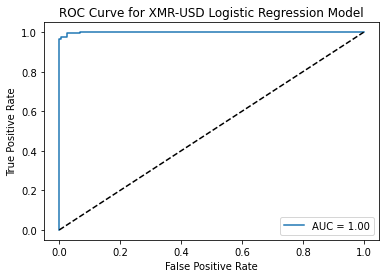

In [16]:
#predict probabilities for X_test
y_pred_prob = model.predict_proba(X_test)[:,1]

#calculate FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

#plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XMR-USD Logistic Regression Model')
plt.legend()
plt.show()


# Some points to mention:
- According to the accuracy of **Decission Tree** and **Logystic Regression** model, we assume that, these two models have faced overiffing
because the accuracy, score precision, recall and f1_score were too high. To make sure that everything is correct, we added
cross validation and normalization to our models, but not only they didn't decrease, but also they got improved.